# Import Dependencies
We begin by importing the necessary libraries. 

In [1]:
# System & OS
import os

# Data analysis
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# ML
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sns.set()
sns.set_style('white')

# Reproducibility

Set the seed to ensure our results are reproducible. 

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 11
set_seed(SEED)

# Data Cleaning

Next, read in the `Batting` dataframe from the `Lahman` package. Note, a separate R script was used to export the data into a CSV file.

In [3]:
# Read data & drop irrelevant columns
df = pd.read_csv('../data/batting_df.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

# Display results
df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,X3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,0,0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,0,0,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,5,0,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,2,2,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,3,0,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


Apply the following cleaning steps:
1. Remove entries that don't fall between 2010 and 2019
2. Remove entries that didn't occur in the National League
3. Remove entries* that have less than 100 plate appearances

*each stint by a given batter in a season is treated as a distinct instance

In [4]:
# Filter for rows between 2010 and 2019
df = df[(df['yearID'] >= 2010) & (df['yearID'] <= 2019)]

# Filter for National League batters
df = df[df['lgID'] == 'NL']

# Create column for number of plate appearances
df['PA'] = df['AB'] + df['BB'] + df['HBP'] + df['SF']
# Filter for rows with PA >= 100
df = df[df['PA'] >= 100].reset_index(drop=True)

# Display results
df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,X3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,PA
0,abreuto01,2010,1,ARI,NL,81,193,16,45,11,1,1,13.0,2.0,1.0,4,47.0,0.0,0.0,0.0,4.0,8.0,201.0
1,alvarpe01,2010,1,PIT,NL,95,347,42,89,21,1,16,64.0,0.0,0.0,37,119.0,1.0,0.0,0.0,2.0,8.0,386.0
2,anderga01,2010,1,LAN,NL,80,155,8,28,6,1,2,12.0,1.0,0.0,5,34.0,1.0,0.0,1.0,2.0,6.0,162.0
3,ankieri01,2010,2,ATL,NL,47,119,17,25,6,1,2,9.0,2.0,1.0,19,42.0,2.0,1.0,0.0,0.0,1.0,139.0
4,bakerje03,2010,1,CHN,NL,79,206,29,56,13,2,4,21.0,1.0,0.0,16,50.0,0.0,1.0,0.0,1.0,6.0,224.0


# Feature Engineering

Then, engineer the following features: 
- Batting average (`BA`): hits / at-bats
- Runs produced (`RP`): runs + runs batted in - homeruns
- Plate appearances (`PA`): at-bats + base on balls + hit by pitch + sacrifice flies
- Runs produced per plate appearance (`RPPPA`): runs produced / plate appearances

Note, `PA` was created in the previous code cell for conditional filtering. 

In [5]:
# Batting average
df['BA'] = df['H'] / df['AB']

# Runs produced
df['RP'] = df['R'] + df['RBI'] - df['HR']

# Runs produced per plate appearance
df['RPPPA'] = df['RP'] / df['PA']

# Display results
df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,X3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,PA,BA,RP,RPPPA
0,abreuto01,2010,1,ARI,NL,81,193,16,45,11,1,1,13.0,2.0,1.0,4,47.0,0.0,0.0,0.0,4.0,8.0,201.0,0.233161,28.0,0.139303
1,alvarpe01,2010,1,PIT,NL,95,347,42,89,21,1,16,64.0,0.0,0.0,37,119.0,1.0,0.0,0.0,2.0,8.0,386.0,0.256484,90.0,0.233161
2,anderga01,2010,1,LAN,NL,80,155,8,28,6,1,2,12.0,1.0,0.0,5,34.0,1.0,0.0,1.0,2.0,6.0,162.0,0.180645,18.0,0.111111
3,ankieri01,2010,2,ATL,NL,47,119,17,25,6,1,2,9.0,2.0,1.0,19,42.0,2.0,1.0,0.0,0.0,1.0,139.0,0.210084,24.0,0.172662
4,bakerje03,2010,1,CHN,NL,79,206,29,56,13,2,4,21.0,1.0,0.0,16,50.0,0.0,1.0,0.0,1.0,6.0,224.0,0.271845,46.0,0.205357


# Target Engineering

Create a target variable for classification. We'll use the median `RPPPA` as a threshold for labeling entries as either 0: "low `RPPPA`", or 1: "high `RPPPA`", where instances at the critical value will be classified as the latter. 

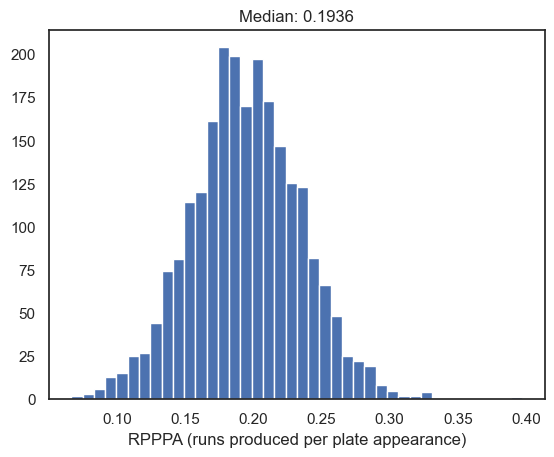

In [6]:
# Visualize the distribution of RPPPA
df['RPPPA'].plot(kind='hist', bins=40)
plt.title(f'Median: {df["RPPPA"].median():.4f}')
plt.xlabel('RPPPA (runs produced per plate appearance)')
plt.ylabel('')
plt.show()

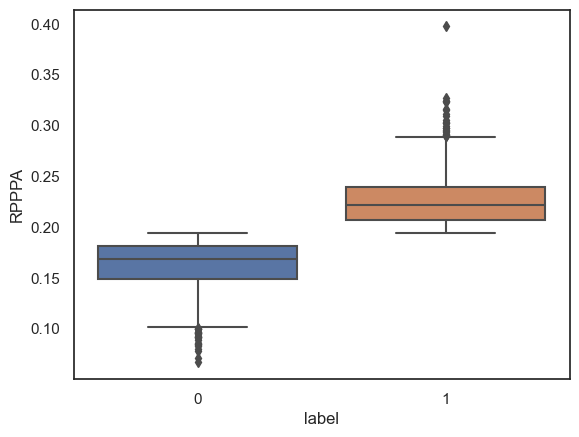

In [7]:
# Create target variable based on median RPPPA value
df['label'] = 0
df.loc[df['RPPPA'] >= df['RPPPA'].median(), 'label'] = 1

# Visualize results using boxplots
sns.boxplot(x='label', y='RPPPA', data=df)
plt.show()

As we can see, all `RPPPA` values below 0.1936 are labeled as low `RPPPA`, and the rest as high `RPPPA`.

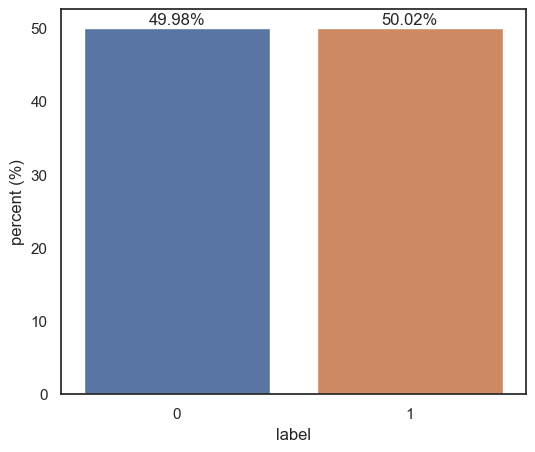

In [8]:
# Perform a normalized value count to obtain the percentage of values in each class
label_counts = df['label'].value_counts(normalize=True).apply(lambda x: x * 100).reset_index()
label_counts.rename(columns={'index': 'label', 'label': 'percent'}, inplace=True)
label_counts.sort_values(by='label', inplace=True)

# Visualize results using a bar graph
plt.subplots(figsize=(6, 5))
sns.barplot(x='label', y='percent', data=label_counts)
plt.ylabel('percent (%)')
for index, value in enumerate(label_counts['percent']):
    plt.text(index, value+0.5, f'{round(value, 2)}%', ha='center')
plt.show()

Additionally, we find that both classes are fairly balanced, with a near 50/50 split.

# Train-Test Split

Moving on, we partition the dataframe into train and test using an 80/20 split. 

In [9]:
# 80/20 train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

# Print results
print(f'Original: {len(df)} entries\nTrain: {len(train_df)} entries\nTest: {len(test_df)} entries')

Original: 2307 entries
Train: 1845 entries
Test: 462 entries


# Null Model

Before fitting any models to the available data, we should determine the accuracy of the null model, which is to be used as a performance benchmark for all future models.

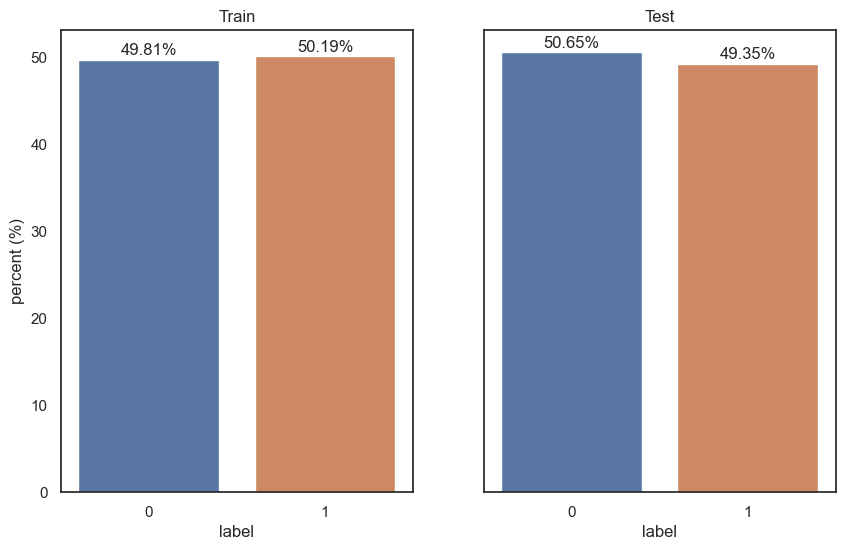

In [10]:
# Perform a normalized value count to obtain the percentage of values in each class
train_label_counts = train_df['label'].value_counts(normalize=True).apply(lambda x: x * 100).reset_index()
train_label_counts.rename(columns={'index': 'label', 'label': 'percent'}, inplace=True)
train_label_counts.sort_values(by='label', inplace=True)

test_label_counts = test_df['label'].value_counts(normalize=True).apply(lambda x: x * 100).reset_index()
test_label_counts.rename(columns={'index': 'label', 'label': 'percent'}, inplace=True)
test_label_counts.sort_values(by='label', inplace=True)

# Visualize results using a bar graph
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.barplot(x='label', y='percent', data=train_label_counts, ax=ax[0])
sns.barplot(x='label', y='percent', data=test_label_counts, ax=ax[1])

ax[0].set_title('Train')
ax[1].set_title('Test')
ax[0].set_ylabel('percent (%)')
ax[1].set_ylabel('')
for index, value in enumerate(train_label_counts['percent']):
    ax[0].text(index, value+0.5, f'{round(value, 2)}%', ha='center')
for index, value in enumerate(test_label_counts['percent']):
    ax[1].text(index, value+0.5, f'{round(value, 2)}%', ha='center')

plt.show()

Notice, the proportion of values belonging to each label remains fairly close to the original dataframe's 50/50 split, implying that the train-test split was most likely executed as expected. Assuming the null model predicts the label to be 0 (i.e. low `RPPPA`) every time, we can expect a baseline accuracy of roughly 50%. 

# Linear Model 1

Next, we'll fit a logistic regression model using k-fold cross validation, with `BA` as our sole predictor. 

In [11]:
# Split the dataframes into X (features) and y (target)
X, y, X_test, y_test = train_df['BA'].values.reshape(-1, 1), train_df['label'].values, test_df['BA'].values.reshape(-1, 1), test_df['label'].values

# Create logistic regression object
model_1 = LogisticRegression()

# Define index & number of splits
i, k = 1, 5
# Create k-fold cross-val object
kf = KFold(n_splits=k)

# Iterate over each fold
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets for the current fold
    X_train, y_train, X_val, y_val = X[train_index], y[train_index], X[val_index], y[val_index]
    
    # Fit the model to train
    model_1.fit(X_train, y_train)

    # Generate model predictions on val
    y_val_pred = model_1.predict(X_val)
    
    # Calculate and print the model's current validation accuracy
    val_accuracy = accuracy_score(y_val, y_val_pred) * 100
    print(f'Fold {i}, validation accuracy: {val_accuracy:.2f}%')
    i += 1

Fold 1, validation accuracy: 68.02%
Fold 2, validation accuracy: 67.21%
Fold 3, validation accuracy: 69.65%
Fold 4, validation accuracy: 66.12%
Fold 5, validation accuracy: 68.83%


Notice, the model's validation accuracy seems to be converging around 68-70%, which is a decent improvement w.r.t. what we'd expect from the null model. Let's visualize the model's decision boundary using the points in test.

Beta_1: 8.0461, Beta_0: -2.0499
BA decision boundary: 0.255


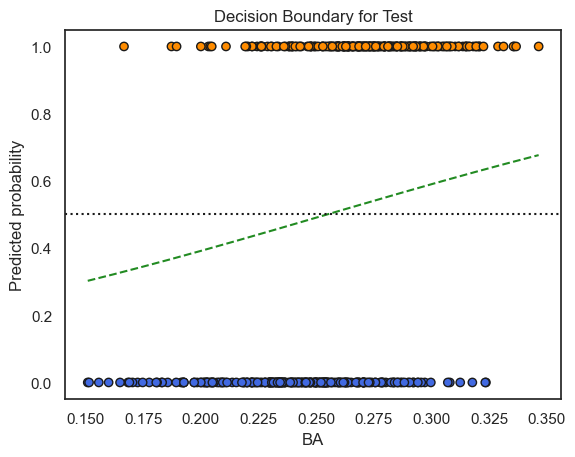

In [12]:
# Print model coefficients
beta_0, beta_1 = model_1.intercept_[0], model_1.coef_[0][0]
thresh = - beta_0 / beta_1
print(f'Beta_1: {beta_1:.4f}, Beta_0: {beta_0:.4f}')
print(f'BA decision boundary: {thresh:.3f}')

# Define logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Define predicted probabilities function
def decision_boundary(model, x):
    return logistic(model.coef_ * x + model.intercept_)[0]

# Define plotting function 
def plot_decision_boundary(model, X, y):
    plt.scatter(X, y, c=y, cmap=mcolors.LinearSegmentedColormap.from_list('my_cmap', [mcolors.CSS4_COLORS['royalblue'], 'white', mcolors.CSS4_COLORS['darkorange']]), edgecolors='k')
    x_plot = np.linspace(np.min(X), np.max(X), 1000)
    y_plot = decision_boundary(model, x_plot)
    plt.plot(x_plot, y_plot, c='forestgreen', linestyle='--')
    plt.axhline(0.5, c='k', linestyle=':')
    plt.title('Decision Boundary for Test')
    plt.xlabel('BA')
    plt.ylabel('Predicted probability')
    plt.show()
    
# Visualize logistic regression's decision boundary with points in test
plot_decision_boundary(model_1, X_test, y_test)

While the decision boundary appears to split & classify the data well, with `BA >= 0.255` being labeled as high `RPPPA`, and `BA < 0.255` low `RPPPA`, we notice it struggles with outliers (i.e. low `RPPPA` with high `BA`, or vice versa), implying that additional features may help the model better differentiate between the two classes. We suspect that the model's ROC curve will provide some more insight.

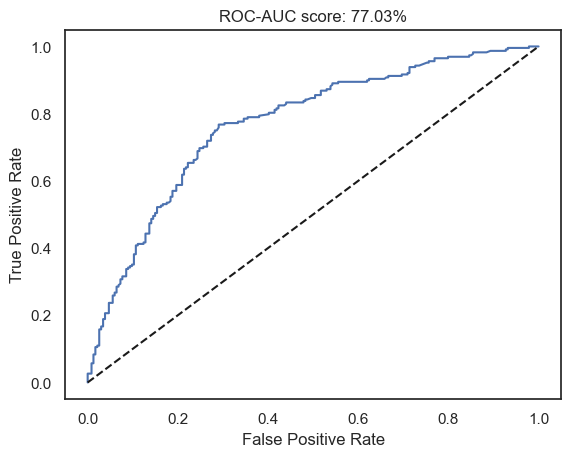

In [13]:
# Extract model's predicted probabilities on test
y_pred_prob = model_1.predict_proba(X_test)[:, 1]

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob) * 100

# Visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-AUC score: {roc_auc:.2f}%')
plt.show()

Indeed, we find with an ROC-AUC score of 77.03% that the model is able to distinguish between the two classes well, performing noticeably better than the null, though there is still some room for improvement. Let's observe the model's accuracy on test via its confusion matrix to see if our claim is supported.

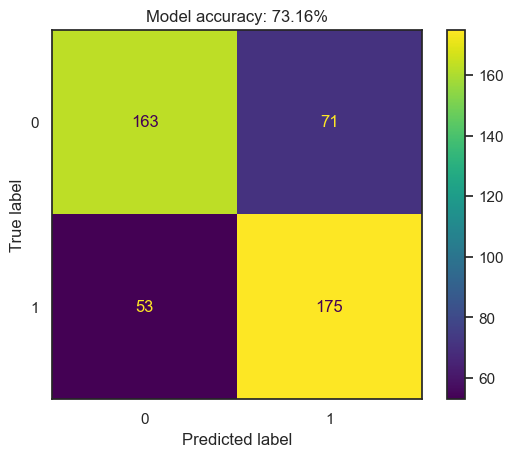

In [14]:
# Generate model predictions on test
y_pred = model_1.predict(X_test)

# Compute model accuracy
accuracy = accuracy_score(y_test, y_pred) * 100

# Calculate and display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Model accuracy: {accuracy:.2f}%')
plt.show()

An accuracy of 73.59% is quite good considering we're only using one predictor, though, again, there does still seem to be more room for improvement. Also notice, our model has a Type I error rate of 14.94%, and a Type II error rate of 11.47%. 

# Linear Model 2

It remains to find additional features that may improve our model's performance. One way of doing so is via a correlation matrix of the original dataframe.

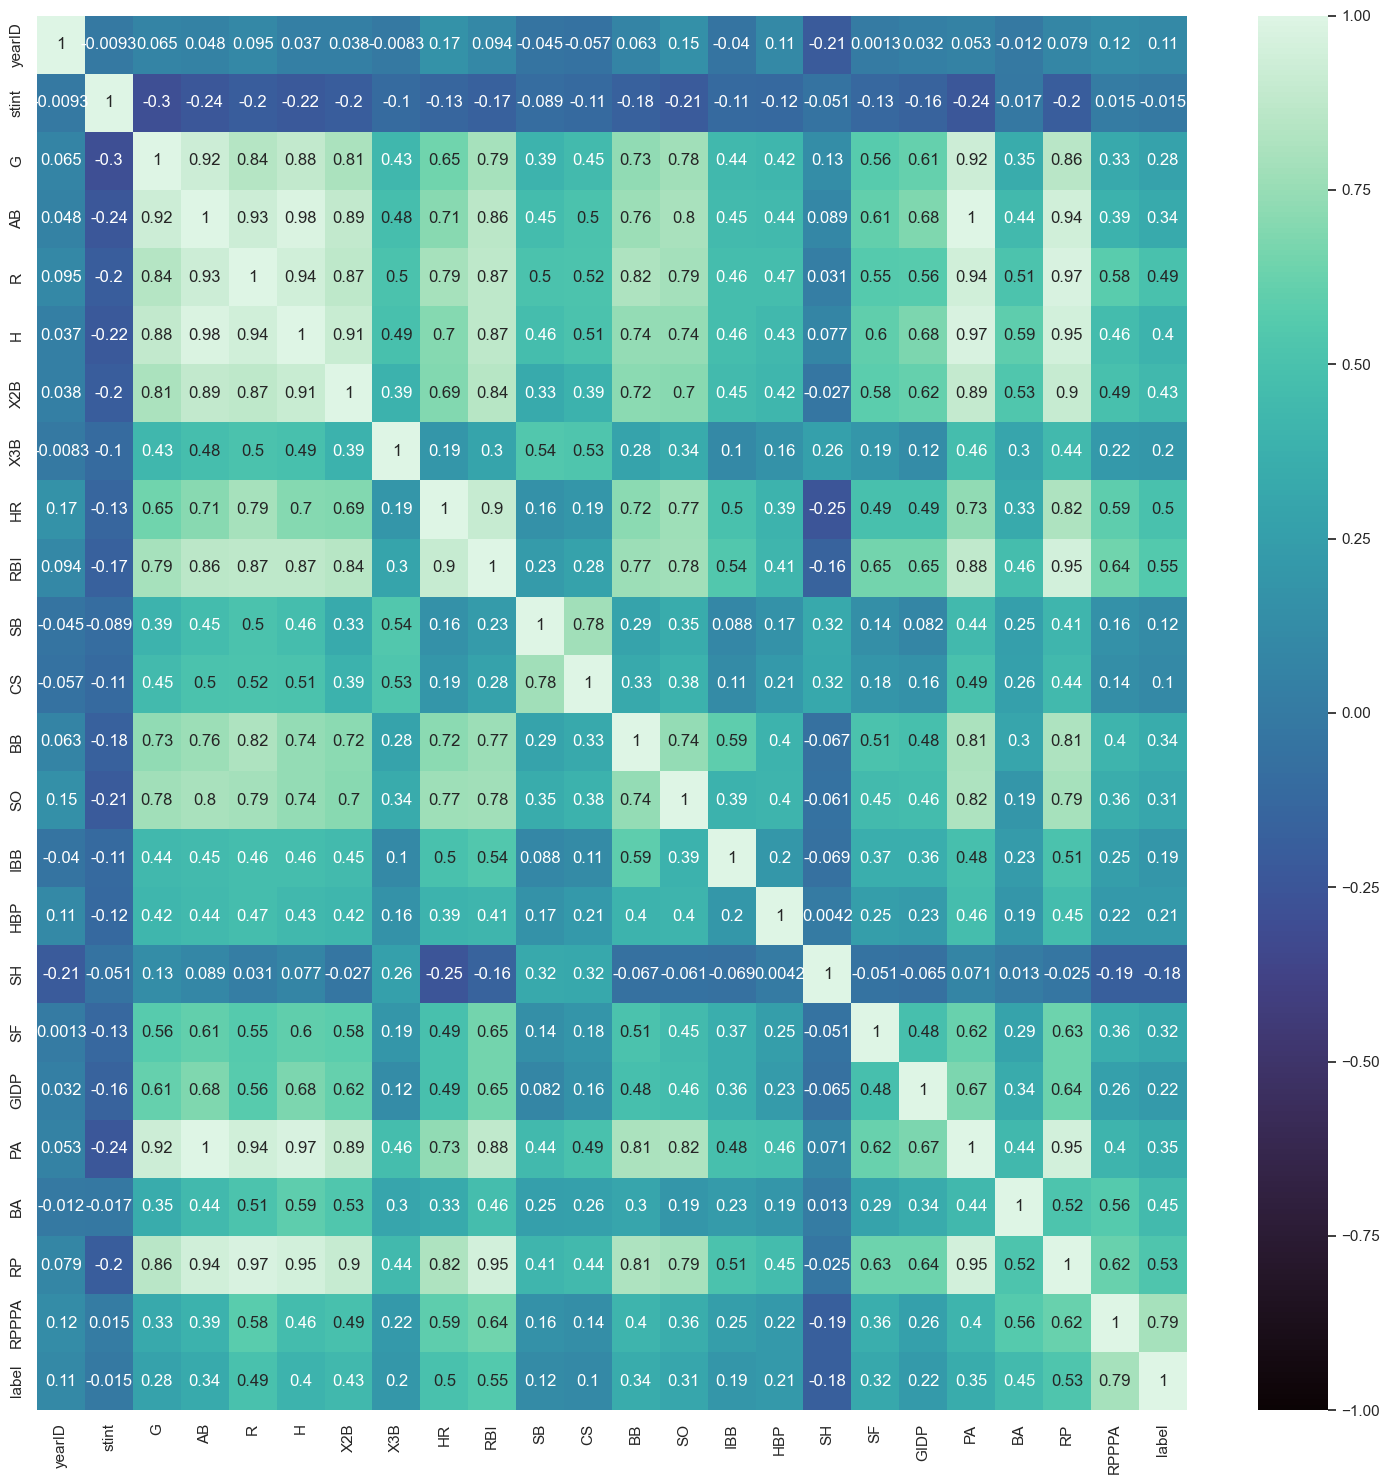

In [15]:
# Plot correlation matrix between features and target
plt.figure(figsize=(15, 15))
corr_heatmap = sns.heatmap(df.corr(), vmin=-1.0, cmap='mako', annot=True)
plt.tight_layout()
plt.show()

In general, we want to identify features that are strongly correlated with the target variable, that aren't mutually correlated with any existing features, and that make sense in the context of the problem (e.g. using `RPPPA` as a predictor for classifying low or high `RPPPA` would likely lead to high accuracy, though the resulting model would prove to be quite meaningless).

To demonstrate what we're looking for, notice the relationship between `RPPPA` and `BA`. 

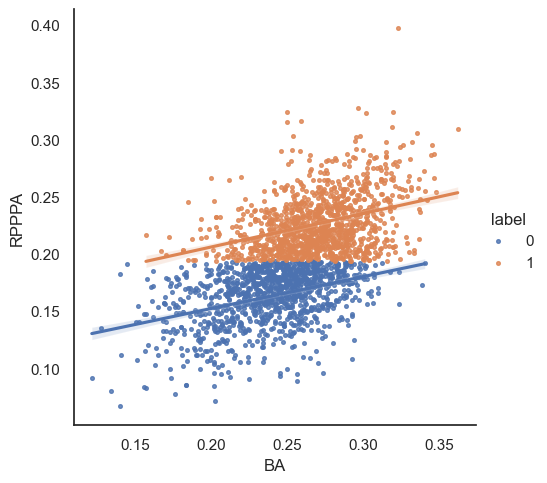

In [16]:
# Generate regression scatter plot
sns.lmplot(data=df, x='BA', y='RPPPA', hue='label', scatter_kws={'s': 7})
plt.show()

There are distinct visual characteristics that help distinguish between the two classes, e.g. a low `BA` likely means low `RPPPA`, etc.

Based on the correlation matrix, we believe `RBI` (runs batted in) will serve as a useful second predictor. 

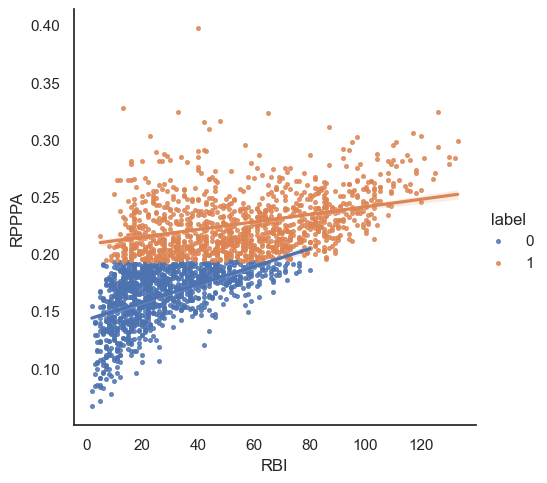

In [17]:
# Generate regression scatter plot
sns.lmplot(data=df, x='RBI', y='RPPPA', hue='label', scatter_kws={'s': 7})
plt.show()

Indeed, this feature will likely be able to help us identify high `RPPPA` cases more consistently, since it's likely implied by a high `RBI`. We proceed accordingly with fitting and evaluating the model.

In [18]:
# Split the dataframes into X (features) and y (target)
X, y, X_test, y_test = train_df[['BA', 'RBI']].values, train_df['label'].values, test_df[['BA', 'RBI']].values, test_df['label'].values

# Create logistic regression object
model_2 = LogisticRegression()

# Define index & number of splits
i, k = 1, 5
# Create k-fold cross-val object
kf = KFold(n_splits=k)

# Iterate over each fold
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets for the current fold
    X_train, y_train, X_val, y_val = X[train_index], y[train_index], X[val_index], y[val_index]
    
    # Fit the model to train
    model_2.fit(X_train, y_train)

    # Generate model predictions on val
    y_val_pred = model_2.predict(X_val)
    
    # Calculate and print the model's current validation accuracy
    val_accuracy = accuracy_score(y_val, y_val_pred) * 100
    print(f'Fold {i}, validation accuracy: {val_accuracy:.2f}%')
    i += 1

Fold 1, validation accuracy: 72.90%
Fold 2, validation accuracy: 76.15%
Fold 3, validation accuracy: 70.19%
Fold 4, validation accuracy: 75.34%
Fold 5, validation accuracy: 71.00%


In [19]:
# Print model coefficients
beta_0, beta_1, beta_2 = model_2.intercept_[0], model_2.coef_[0][0], model_2.coef_[0][1]
print(f'\nBeta_2: {beta_2:.4f}, Beta_1: {beta_1:.4f}, Beta_0: {beta_0:.4f}')

# Print decision boundaries using mean of unused predictor
BA_mean, RBI_mean = X[:, 0].mean(), X[:, 1].mean()
thresh_1, thresh_2 = - (beta_0 + beta_2 * RBI_mean) / beta_1, - (beta_0 + beta_1 * BA_mean) / beta_2
print(f'BA Decision boundary: {thresh_1:.3f}\nRBI Decision boundary: {thresh_2:.0f}')


Beta_2: 0.0594, Beta_1: 3.8514, Beta_0: -3.2459
BA Decision boundary: 0.212
RBI Decision boundary: 38


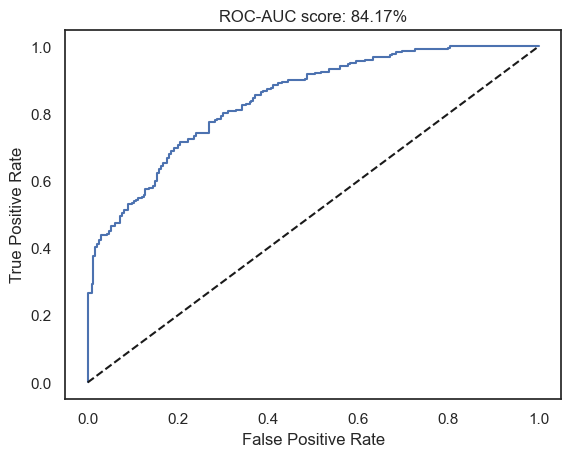

In [20]:
# Extract model's predicted probabilities on test
y_pred_prob = model_2.predict_proba(X_test)[:, 1]

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob) * 100

# Visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-AUC score: {roc_auc:.2f}%')
plt.show()

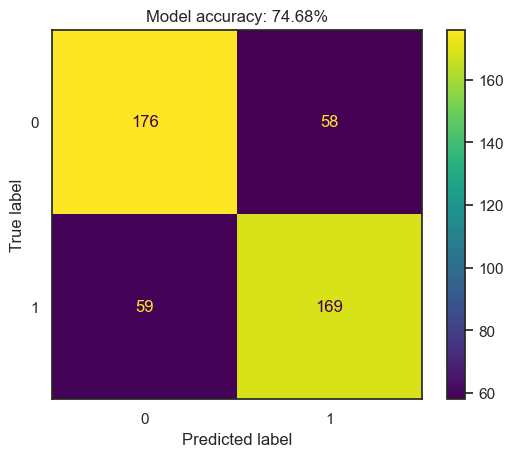

In [21]:
# Generate model predictions on test
y_pred = model_2.predict(X_test)

# Compute model accuracy
accuracy = accuracy_score(y_test, y_pred) * 100

# Calculate and display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Model accuracy: {accuracy:.2f}%')
plt.show()

Now, we notice a few things:
- the validation accuracy is converging to 75-76% (1.1x improvement from `model_1`)
- the ROC-AUC score is at 84.17% (1.09x increase from `model_1`)
- the model scored 74.68% accuracy on test (up 1.02x from `model_1`)
- the model's Type I and II error rates are 12.55% (down 0.84x from `model_1`) and 12.77% (up 1.11x from `model_1`), respectively

Thus, by four out of five available metrics, `model_2` (marginally) outperforms `model_1`. Additionally, both models significantly outperform the null model.

Furthermore, the model's decision boundaries are obtained by inverting the logistic function and solving for the critical value when the predicted probability is 50%. Since there are two predictors at play, we'll assume the mean of the non-variable-of-interest when considering the variable-of-interest. Doing so yields a boundary of `BA >= 0.212` belonging to high `RPPPA`, and `BA < 0.212` low `RPPPA`; `RBI >= 38` as high `RPPPA`, and `RBI < 38` low `RPPPA`. 

Interestingly, our hypothesis that the `RBI` feature would help the model better identify high `RPPPA` instances has seemingly been proven true, since the model shifted the boundary for `BA` back by 16.86% to include more high `RPPPA` cases, resulting in a lower false positive rate, at the expense of a higher false negative rate.